## Simulation Tests

Fixed conditions comprise of sampling time (1600 timesteps to reflect 20 minute flight in seconds), survey area (7500m x 7500m) and sensor detection zone (based on camera model). Changing variables per flight will reflect survey effort and animal availability:

1.Survey Effort

* UAV path (Lawn-mower/ Figure 8)
* FOV (BIOT/ Maldives)
* UAV speed (lowest speed-average/ average-max speed)

2.Animal availability

* Animal movement model (Straight Line/ Stop-Start/ Random Walk)
* Animal speed (different per taxa)
* Availability bias (None/Sharks/Rays/Birds)


### Parameter Functions
These functions include:
* Selecting detection zone
* Start coord of UAV depending on camera type
* Establishing seperate speed profiles
* Sample points - number of coordinates and x, y values between 2 points in flight path

In [1]:
def detection_zone(camera):
    # FOV calculated per camera model in Strip_Sampling_Density.
    
    camdict = {"garmin": [83,113], "sony": [113, 75]}
    try:
        return camdict[camera.lower()]
    except KeyError:
        raise KeyError ('Invalid camera model used, should be :{}'.format([x for x in camdict.keys()]))

In [2]:
detection_zone('GARMIN')

[83, 113]

In [3]:
def boundary_coords_uav(camera):
    
    # x and y coordinates 
    
    area = detection_zone(camera)
    half_area = [x/2  for x in area]
    boundary = {'coord_1' : [(0 + half_area[0]), (0 + half_area[1])],
                'coord_2' : [(7500 - half_area[0]), (0 + half_area[1])],
                'coord_3' : [(7500 - half_area[0]), (7500 - half_area[1])],
                'coord_4' : [(0 + half_area[0]), (7500 - half_area[1])]}
    
    return boundary

boundary_coords_uav('sony')

{'coord_1': [56.5, 37.5],
 'coord_2': [7443.5, 37.5],
 'coord_3': [7443.5, 7462.5],
 'coord_4': [56.5, 7462.5]}

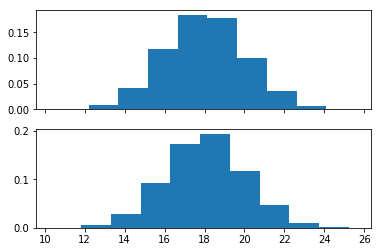

In [66]:
from scipy.stats import truncnorm
import scipy.stats as stats
import matplotlib.pyplot as plt

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    # More intuitive method to use truncnorm for speed_profile distribution

    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)



def speed_profile (level, mean = 18, sd = 1, low = 4, upp = 33):
    # Speed profile for random sample distribution
    # Average speed: 18 m/s 
    # Level 1 = low, Level 2 = high
    
    speed_dist = get_truncated_normal(mean, sd, low, upp)
    value = speed_dist.rvs(size=1) # Select 1 random number from this distribution
    if level == 1:
        while value > mean:
            value = speed_dist.rvs(size=1)
    else:
        while value < mean:
            value = speed_dist.rvs(size=1)
            
    return value[0]

# Show graphics
#lower, upper = 4, 33
#mu, sigma = 18, 2
#X = stats.truncnorm(
#    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#N = stats.norm(loc=mu, scale=sigma)

#fig, ax = plt.subplots(2, sharex=True)
#ax[0].hist(X.rvs(10000), normed=True) # truncated normal dist
#ax[1].hist(N.rvs(10000), normed=True) # normal dist
#plt.show()


### Speed profiles of animal

#### Elasmos
* Grey reef shark cruise speed - 0.64m/s | max cruise speed - 1.23(Ryan, 15)
* Nurse shark cruise speed is 0.3Bl/s - 0.33m/s ((((91+132)/2)/100)*0.3) | max - ((132/100)*0.74) (Whitney, 16)
* Average whale shark is 0.6m/s | max - 1.06 (Jacoby,18)
* Average ray speed is 1.42 m/s | max - 2.51 (Fish, 18) - could find manta but not eagle
* Average manatee speed is 0.7m/s | max - 1.14(Kojeszewski, 07)

#### Birds
* Red-footed boobies travel at median speed of 38km/h - 10.5m/s | max - 22m/s (Weimerskirch, 05)
* Frigatebird average is 16.4km/h - 4.5 m/s | 5.1 (Weimerskirch,03)
* Common tern average is 30km/h - 8.3 m/s (Nisbet, I C T. The Birds of North America Online (2002: series Alan Poole) (ed.). "Common Tern (Sterna hirundo)". Cornell Lab of Ornithology. Retrieved 25 January 2012. Subscription needed for full text.)



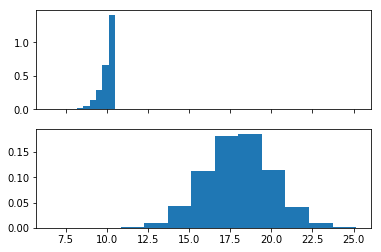

In [109]:
from matplotlib import pyplot as plt
import statistics
import math


def animal_speed (animal):
    # Speed distribution is based on crude figures for each animal taxa
    
    speed_dict = {"reef": [0.64, 1.23], "nurse": [0.33, 0.98], "whale_shark" : [0.6, 1.06], "ray": [1.42, 2.51], 
                  "manatee": [0.7, 1.14], "booby": [10.5, 22], "frigate": [4.5, 5.1], "tern": [8.3, 11.94]}
    
    mean = speed_dict[animal.lower(0)]
    # sd = 1
    #speed_dist = get_truncated_normal(mean, sd, low, upp)
    #value = speed_dist.rvs(size=1)
    return mean


# Show graphics
lower, upper = 0.1, 10.5
mu, sigma = 18, 2
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
N = stats.norm(loc=mu, scale=sigma)

fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(X.rvs(10000), normed=True) # truncated normal dist
ax[1].hist(N.rvs(10000), normed=True) # normal dist
plt.show()

In [110]:
animal_speed(reef)

NameError: name 'reef' is not defined

In [92]:
import math
from decimal import *
import numpy as np

def convert_ints(x):
    if x < 0.001:
        return 0



def find_sample_points(start_coord, end_coord, angle, speed_level, probability = 0):

    # Retrieves coordinates for x number of timesteps between 2 points
    
    # start_coord = start point of animal or drone
    # end_coord = end point of animal or drone
    # angle = angle of travel in degrees
    # speed_level = low(1) or high(2)
    # probability = probability of animal remaininh stationary in that timestep(default = 0)

    horiz_dist = abs(end_coord[0] - start_coord[0]) # x coordinates
    vert_dist = abs(end_coord[1] - start_coord[1]) # y coordinates
    length = math.sqrt((horiz_dist**2) + (vert_dist**2)) # length in metres between both points
    angle_radians = math.radians(angle)

    
    total_length_covered = 0
    x_list = [start_coord[0]] # list of x values at every step
    y_list = [start_coord[1]] # list of y values at every step
    iteration = 0 # used to cumulatively add the last x, y values to recent

    while True:
        s = speed_profile(speed_level) # get our speed for this step
        total_length_covered += s # cumulatively add to total length covered
        if total_length_covered > length:
            break
        
        point_probability = np.random.choice(100,1) # assign probability to coordinate
        #print(point_probability)
        if point_probability > probability:
            delta_x = x_list[iteration] + (math.cos(angle_radians)* s) # From start x coordinate, add the length with direction calculated through cosine 
            delta_y = y_list[iteration] + (math.sin(angle_radians)* s) # From start y coordinate, add the length with direction calculated through sine
       
        
            #x = delta_x.astype(np.int64) # From float to int for rounding purposes
            #y = delta_y.astype(np.int64) # From float to int for rounding purposes
            
            getcontext().prec = 20
            print(Decimal(delta_x))
            print(Decimal(delta_y))
            
            
            x_list.append(delta_x) 
            y_list.append(delta_y)
        
        else:
            total_length_covered = total_length_covered - s # Take last distance as we have not travelled here
            x_list.append(x_list[iteration]) 
            y_list.append(y_list[iteration])

        iteration += 1


    sample_coords = list(zip(x_list, y_list))     # zip up to create list of tuples, each being a set of coordinates where a sample has been taken
    
    Actual_length = total_length_covered - s
    
    
    return sample_coords 

In [93]:
test = find_sample_points([0,0], [100,0], 360, 1)
test

17.5521145943604324202169664204120635986328125
-4.2990281912502091419303633381443930638267001374808184976927805109880864620208740234375E-15
33.868841631008763215504586696624755859375
-8.295473698848700898007793494586810072511143775153552581969051971100270748138427734375E-15
51.5084239505739134301620651967823505401611328125
-1.2615925304039041135256084147939317696834600306121654256230613100342452526092529296875E-14
68.7684553000182177129318006336688995361328125
-1.6843413733095032467569825055223060788285767419569793901246157474815845489501953125E-14
86.4784144043134119783644564449787139892578125
-2.118110267911615835822986426572501730930769663074908493172188173048198223114013671875E-14


[(0, 0),
 (17.552114594360432, -4.2990281912502091e-15),
 (33.868841631008763, -8.2954736988487009e-15),
 (51.508423950573913, -1.2615925304039041e-14),
 (68.768455300018218, -1.6843413733095032e-14),
 (86.478414404313412, -2.1181102679116158e-14)]

In [50]:
def random_walk (start_coord, probability):
    

[1, 2]


### UAV and Animal path functions